In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import random

from os import listdir
from os.path import isfile, join

# define a set of colors for later visualizations
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get all trajectory files under the folder
mypath = "/content/drive/MyDrive/lab geo ai 503 /data/Trajectory"
traj_files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]

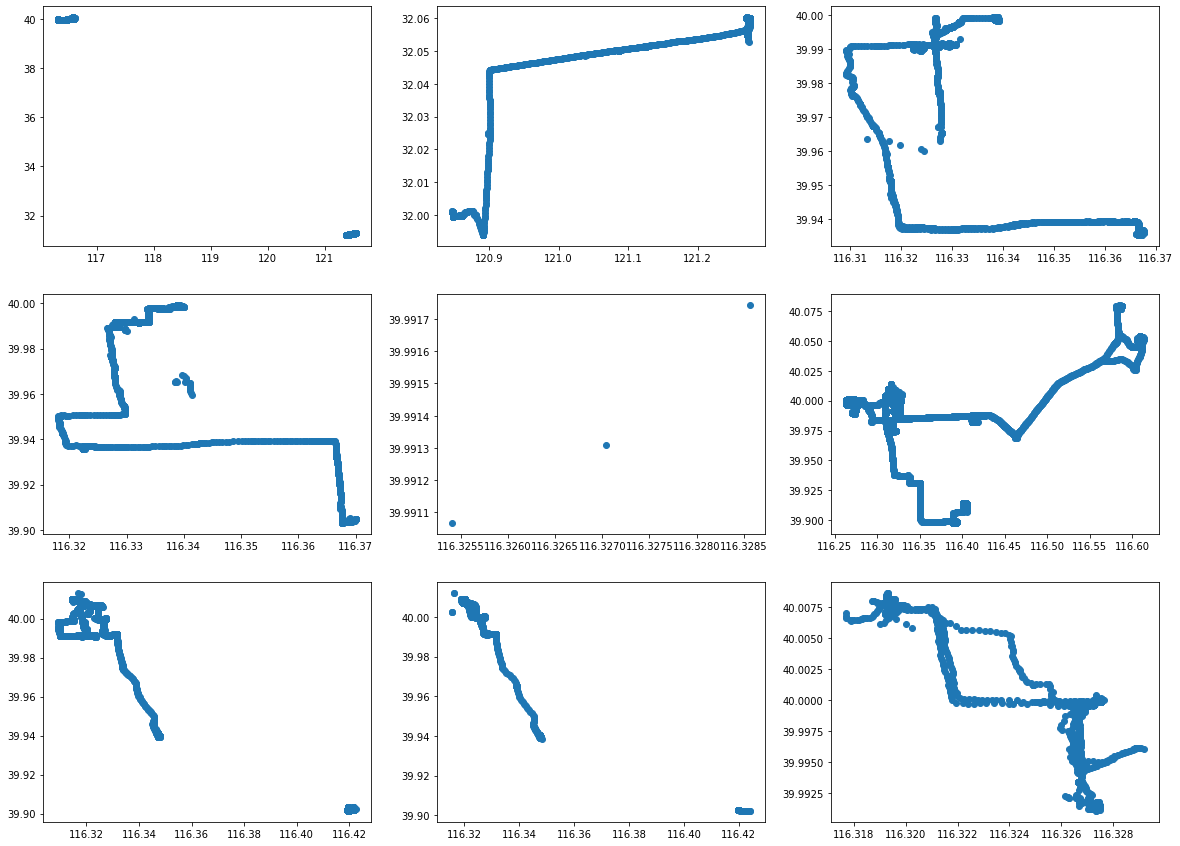

In [ ]:
# Task 1: Randomly visualize 9 trajectories
plt.figure(figsize=(20,15))
for i in range(9):
  plt.subplot(3,3,i+1)
  traj_index = random.randint(0, len(traj_files)-1)
  this_traj = pd.read_csv(traj_files[traj_index], header=None,skiprows=6)
  this_traj.columns=["lat","lng","zero","elevation","longtimestring","date", "time"]
  plt.scatter(this_traj["lng"], this_traj["lat"])
  plt.ticklabel_format(useOffset=False)


In [ ]:
# Task 2: Define your DBSCAN model 
dbscan = DBSCAN(eps=0.002, min_samples=72) #1 dgr = 100,000 meters ; 5 seconds/pt

def plot_dbscan_result(model, X):
  plt.figure(figsize=(10,8))
  y_label = model.fir_predict(X)
  unique_label = set(y_label)
  n_cluster = len(unique_label)
  if -1 in unique_label:
    n_cluster = n_cluster -1 
  for cluster_i in range(n_cluster):
    plt.scatter(X[:,0][y_label == cluster_i],X[:1][y_label== cluster_i],c=colors[cluster_i])

  plt.scatter(X[:,0][y_label==-1],X[:,1][y_label==-1], c="k")


In [ ]:
# Apply DBSCAN to all the trajectories of this individual
AOI_centers = []
traj_center_sequence = []

for i in range(len(traj_files)):
  # Read trajectory one by one
  this_traj = pd.read_csv(traj_files[i],header=None,skiprows=6)
  this_traj.columns=["lat","lng","zero","elevation","longtimestring","date","time"]
  loc_array = np.column_stack((this_traj["lng"].to_numpy(),this_traj["lat"].to_numpy()))

  # DBSCAN clustering
  X = loc_array
  y_label = dbscan.fit_predict(X)
  unique_label = set(y_label)
  n_cluster = len(unique_label)
  if -1 in unique_label:
      n_cluster = n_cluster - 1

  # Add the clustering result to the two lists
  if n_cluster ==0:
    continue

  this_traj_center_seq = []
  for cluster_i in range(n_cluster):
    cluster_center = [np.mean(X[:,0][y_label== cluster_i]), np.mean(X[:,1][y_label== cluster_i])]
    this_traj_center_seq.append(cluster_center)

    # add to AOI centers
    find_similar_center = False
    for aoi_index in range(len(AOI_centers)):
      dist = np.sqrt((cluster_center[0] - AOI_centers[aoi_index][0])**2 + (cluster_center[1] - AOI_centers[aoi_index][1])**2)
      if dist < 0.004:
        new_center = [(cluster_center[0] + AOI_centers[aoi_index][0])/2,(cluster_center[1] + AOI_centers[aoi_index][1])/2]
        AOI_centers.remove(AOI_centers[aoi_index])
        AOI_centers.insert(aoi_index, new_center)
        find_similar_center = True
        break

    if find_similar_center == False:
      AOI_centers.append(cluster_center)

  if len(this_traj_center_seq) >1:
    traj_center_sequence.append(this_traj_center_seq)



In [ ]:
# Task 2: How many AOI centers are there for this individual?
len(AOI_centers)

167

In [ ]:
# Task 2: How many trajectory sequences are detected?
len(traj_center_sequence)

167

In [ ]:
# Convert trajectories into sequences
output = open("/content/sequence.txt","w")

for traj_index in range(len(traj_center_sequence)):
  traj_string_seq = ""
  for stop_index in range(len(traj_center_sequence[traj_index])):
    this_stop = traj_center_sequence[traj_index][stop_index]
    
    min_distance = 180
    min_distance_aoi = -1
    for aoi_index in range(len(AOI_centers)):
      this_dist = np.sqrt((this_stop[0] - AOI_centers[aoi_index][0])**2 + (this_stop[1] - AOI_centers[aoi_index][1])**2)
      if this_dist < min_distance:
        min_distance = this_dist
        min_distance_aoi = aoi_index

    traj_string_seq += str(min_distance_aoi)+","

  output.write(traj_string_seq[:-1]+"\n")


output.close()

In [ ]:
# save AOI center to file
output2 = open("/content/aoi_center.txt","w")

output2.write("aoi_index,lng,lat\n")

for aoi_index in range(len(AOI_centers)):
  output2.write(str(aoi_index)+","+str(AOI_centers[aoi_index][0])+","+str(AOI_centers[aoi_index][1])+"\n")

output2.close()

In [ ]:
# Task 3: Read trajectory sequences into a list
traj_sequences = []

with open("/content/sequence.txt", "r") as sequenceFile:
  for line in sequenceFile:
    this_traj = line.split(",")
    this_traj = [int(i) for i in this_traj]
    traj_sequences.append(this_traj)


In [ ]:
# Generate training data
# Because the existing data is small, one way to increase the number of training 
# data is to break one longer sequence into multiple shorter sequences

# Here, we are going to generate sequence data with previous stops from 1 to 4
# Thus, we will have four groups of training data and test data

previous_stops_data = [] # a list container for all four groups of data (previous stops)
next_stop_label = [] # a list container for all four groups of data (labels)

for stop_count in range(1,5):
  this_previous_stops = [] # a list container for one group of data (e.g., 1 stop) 
  this_next_stop = [] # a list container for one group of data (the label of this data) 
  for traj_index in range(len(traj_sequences)):
    this_traj = traj_sequences[traj_index]
    this_traj_len = len(this_traj)
    if this_traj_len<(stop_count+1):
      continue
    
    for stop_index in range(this_traj_len-stop_count):
      this_traj_previous_stops = []
      for stop_offset in range(stop_count):
        this_traj_previous_stops.append(this_traj[stop_index+stop_offset])
      this_previous_stops.append(this_traj_previous_stops)
      this_next_stop.append(this_traj[stop_index+stop_count])

  # Get the data in this group and convert them to numpy array
  this_previous_stops = np.array(this_previous_stops)
  this_previous_stops = this_previous_stops[..., np.newaxis]
  this_next_stop = np.array(this_next_stop)

  # Add this group of data to the container
  previous_stops_data.append(this_previous_stops)
  next_stop_label.append(this_next_stop)


In [ ]:
# Task 3: Split data into 80% for training and 20% for testing
# Note that you will have four groups of data
from sklearn.model_selection import train_test_split

train_X = []
train_label = []

test_X = []
test_label = []

for i in range(4):
  this_train_X, this_test_X, this_train_label, this_test_label = train_test_split(previous_stops_data[i],  next_stop_label[i], test_size=0.2, random_state=42)
  train_X.append(this_train_X)
  train_label.append(this_train_label)

  test_X.append(this_test_X)
  test_label.append(this_test_label)

In [ ]:
# Task 4: Train and test a SimpleRNN model and a model of your choice; compare their performances
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.random.set_seed(42)
aoi_count = len(AOI_centers)

#simpleRNN
rnn_model = keras.Sequential([
                               keras.layers.SimpleRNN(512, input_shape=[None,1], return_sequences=True),
                               keras.layers.Dropout(0.2),
                               keras.layers.SimpleRNN(256),
                               keras.layers.Dense(aoi_count, activation = "softmax")
])

#hybrid
hybrid_model = keras.Sequential([
                               keras.layers.LSTM(512, input_shape=[None,1], return_sequences=True),
                               keras.layers.Dropout(0.2),
                               keras.layers.SimpleRNN(256),
                               keras.layers.Dense(aoi_count, activation = "softmax")
])

In [ ]:
rnn_model.compile(optimizer="adam", loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
hybrid_model.compile(optimizer="adam", loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [ ]:
rnn_model.fit(train_X[0], train_label[0], epochs = 10)
rnn_model.fit(train_X[1], train_label[1], epochs = 10)
rnn_model.fit(train_X[2], train_label[2], epochs = 10)
rnn_model.fit(train_X[3], train_label[3], epochs = 10)

Epoch 1/10
12/12 [==============================] - 1s 8ms/step - loss: 5.1608 - accuracy: 0.0474
Epoch 2/10
12/12 [==============================] - 0s 8ms/step - loss: 4.6359 - accuracy: 0.0742
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 4.6016 - accuracy: 0.0943
Epoch 4/10
12/12 [==============================] - 0s 9ms/step - loss: 4.4146 - accuracy: 0.0897
Epoch 5/10
12/12 [==============================] - 0s 8ms/step - loss: 4.4494 - accuracy: 0.0826
Epoch 6/10
12/12 [==============================] - 0s 8ms/step - loss: 4.3884 - accuracy: 0.0805
Epoch 7/10
12/12 [==============================] - 0s 8ms/step - loss: 4.3662 - accuracy: 0.0905
Epoch 8/10
12/12 [==============================] - 0s 8ms/step - loss: 4.2569 - accuracy: 0.1160
Epoch 9/10
12/12 [==============================] - 0s 9ms/step - loss: 4.1976 - accuracy: 0.0941
Epoch 10/10
12/12 [==============================] - 0s 7ms/step - loss: 4.2657 - accuracy: 0.0994
Epoch 1/10
8/8 [===

In [ ]:
hybrid_model.fit(train_X[0], train_label[0], epochs = 10)
hybrid_model.fit(train_X[1], train_label[1], epochs = 10)
hybrid_model.fit(train_X[2], train_label[2], epochs = 10)
hybrid_model.fit(train_X[3], train_label[3], epochs = 10)

Epoch 1/10
12/12 [==============================] - 2s 18ms/step - loss: 5.0756 - accuracy: 0.0432
Epoch 2/10
12/12 [==============================] - 0s 18ms/step - loss: 4.6879 - accuracy: 0.0734
Epoch 3/10
12/12 [==============================] - 0s 17ms/step - loss: 4.5917 - accuracy: 0.0918
Epoch 4/10
12/12 [==============================] - 0s 20ms/step - loss: 4.4266 - accuracy: 0.0860
Epoch 5/10
12/12 [==============================] - 0s 20ms/step - loss: 4.3777 - accuracy: 0.0986
Epoch 6/10
12/12 [==============================] - 0s 19ms/step - loss: 4.3037 - accuracy: 0.0780
Epoch 7/10
12/12 [==============================] - 0s 19ms/step - loss: 4.2891 - accuracy: 0.0973
Epoch 8/10
12/12 [==============================] - 0s 18ms/step - loss: 4.1574 - accuracy: 0.1154
Epoch 9/10
12/12 [==============================] - 0s 19ms/step - loss: 4.0972 - accuracy: 0.0993
Epoch 10/10
12/12 [==============================] - 0s 19ms/step - loss: 4.1343 - accuracy: 0.0916
Epoch 1/1

In [ ]:
#simple RNN
test_pred = []
for i in range(4):
  test_pred.append(np.argmax(rnn_model.predict(test_X[i]), axis=-1))

In [ ]:
#hybrid
test_pred2 = []
for i in range(4):
  test_pred2.append(np.argmax(hybrid_model.predict(test_X[i]), axis=-1))

In [ ]:
from sklearn.metrics import accuracy_score
for i in range(4):
  this_accuracy = accuracy_score(test_label[i], test_pred[i])
  print("As for the simple RNN model, the accuracy of next-stop predictoin based on " + str(i)+"existing location(s) is:"+str(this_accuracy)+"\n")

As for the simple RNN model, the accuracy of next-stop predictoin based on 0existing location(s) is:0.053763440860215055

As for the simple RNN model, the accuracy of next-stop predictoin based on 1existing location(s) is:0.05084745762711865

As for the simple RNN model, the accuracy of next-stop predictoin based on 2existing location(s) is:0.13157894736842105

As for the simple RNN model, the accuracy of next-stop predictoin based on 3existing location(s) is:0.0



In [ ]:
for i in range(4):
  this_accuracy = accuracy_score(test_label[i], test_pred2[i])
  print("As for the hybrid model, the accuracy of next-stop predictoin based on " + str(i)+"existing location(s) is:"+str(this_accuracy)+"\n")

As for the hybrid model, the accuracy of next-stop predictoin based on 0existing location(s) is:0.021505376344086023

As for the hybrid model, the accuracy of next-stop predictoin based on 1existing location(s) is:0.05084745762711865

As for the hybrid model, the accuracy of next-stop predictoin based on 2existing location(s) is:0.34210526315789475

As for the hybrid model, the accuracy of next-stop predictoin based on 3existing location(s) is:0.08695652173913043



Compared to the accuracy on test data, it seems like the hybrid model has better performance